# Prima prova di neural network

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
#from tqdm.notebook import tqdm, trange
from tqdm.auto import tqdm, trange
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
import json
import sys
import time

prendo i dati, li leggo e li splitto

In [32]:
train = None
with open('../data/images/data.json', 'r') as f:
    train = json.load(f)
labels = {}
train_img = []
y = []
for img_name, type in tqdm(train.items()):
    labels[type] = True
    y.append(type)
    image_path = '../data/' + str(img_name)
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    train_img.append(img)


numLabel = len(labels)
# converting the list to numpy array
X = np.array(train_img)
y = np.array(y)

  0%|          | 0/12 [00:00<?, ?it/s]

One hot encoding

In [33]:
oneHot = False

In [34]:
if oneHot:
    one = preprocessing.OneHotEncoder()
    y = one.fit_transform(y.reshape(-1,1)).toarray()
    pickle.dump(one, open('oneHotEncoder.pickle', 'wb'))
else:
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    # print the classes
    print(le.classes_)
    pickle.dump(le, open('labelEncoder.pickle', 'wb'))

['H' 'none']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)

#X_train = X_train.reshape(len(X), 16, 16)
X_train  = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

# converting the target into torch format
y_train = y_train.astype(int)
y_train = torch.from_numpy(y_train)
y_test = y_test.astype(int)
y_test = torch.from_numpy(y_test)

# shape of training data
X_train.shape, y_train.shape

(torch.Size([10, 16, 16]), torch.Size([10]))

In [8]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)
y_test = y_test.type(torch.LongTensor)
y_train = y_train.type(torch.LongTensor)

In [9]:
test = TensorDataset(X_test, y_test)
train = TensorDataset(X_train, y_train)

creo i batch, randomizzando i dati, con un dataloader

In [10]:
batch_size = 50

# Create data loaders.
test = DataLoader(test, batch_size=batch_size, shuffle=True)
train = DataLoader(train, batch_size=batch_size, shuffle=True)

for X, y in test:
    print(f"Shape of X : {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X : torch.Size([2, 1, 16, 16])
Shape of y: torch.Size([2]) torch.int64


# creo la neural network

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [12]:
# moved definition to other file, so I can dump the model
from CNN import NeuralNetwork

In [13]:
model = NeuralNetwork(numLabel=numLabel).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50, out_features=2, bias=True)
    (2): LogSoftmax(dim=1)
  )
)


In [14]:
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
LEARNING_RATE = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()

In [19]:
train_losses = []
def trainf(dataloader, model, loss_fn, optimizer):
    global best_model
    best_loss = float("inf")
    size = len(dataloader.dataset)
    #model.double()
    model.train()
    for batch , (X, Y) in tqdm(enumerate(dataloader), leave=False, total=len(dataloader), position=1, file=sys.stdout):
        X, Y = X.to(device), Y.to(device)
        loss = float("inf")
        optimizer.zero_grad()
        # Compute prediction error
        #output = torch.argmax(X, dim=1).float()
        pred = model(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        # Backpropagation
        optimizer.step()

        if loss < best_loss:
            best_loss = loss
            best_model = deepcopy(model)

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_losses.append(loss)
            tqdm.write(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
def testf(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        gas_avg_loss = [0 for _ in range(5)]
        for X, Y in dataloader:
            gas_loss = [([],[]) for _ in range(5)]
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            for i, (gas, y_lin) in enumerate(zip(pred, Y)):
                gas_loss[i][0].append(y_lin)
                gas_loss[i][1].append(gas)
            test_loss += loss_fn(pred, Y).item()
    test_loss /= num_batches * batch_size
    tqdm.write(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


In [22]:
epochs = 20
train_losses = []
val_losses = []
for t in trange(epochs, file=sys.stdout):
    trainf(train, model, loss_fn, optimizer)
    testf(test, model, loss_fn)
torch.save(model.state_dict(), 'nn.torch')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.326654  [    0/   10]
Test Error: 
 Avg loss: 0.001677 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.327332  [    0/   10]
Test Error: 
 Avg loss: 0.001627 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.327985  [    0/   10]
Test Error: 
 Avg loss: 0.001587 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.328568  [    0/   10]
Test Error: 
 Avg loss: 0.001557 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.329049  [    0/   10]
Test Error: 
 Avg loss: 0.001536 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.329409  [    0/   10]
Test Error: 
 Avg loss: 0.001523 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.329637  [    0/   10]
Test Error: 
 Avg loss: 0.001517 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.329732  [    0/   10]
Test Error: 
 Avg loss: 0.001519 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.329701  [    0/   10]
Test Error: 
 Avg loss: 0.001527 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.329556  [    0/   10]
Test Error: 
 Avg loss: 0.001541 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.329315  [    0/   10]
Test Error: 
 Avg loss: 0.001560 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.328995  [    0/   10]
Test Error: 
 Avg loss: 0.001583 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.328618  [    0/   10]
Test Error: 
 Avg loss: 0.001611 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.328203  [    0/   10]
Test Error: 
 Avg loss: 0.001642 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.327771  [    0/   10]
Test Error: 
 Avg loss: 0.001676 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.327338  [    0/   10]
Test Error: 
 Avg loss: 0.001713 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.326920  [    0/   10]
Test Error: 
 Avg loss: 0.001752 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.326531  [    0/   10]
Test Error: 
 Avg loss: 0.001791 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.326178  [    0/   10]
Test Error: 
 Avg loss: 0.001832 



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1, 16, 16])
torch.float32
loss: 0.325869  [    0/   10]
Test Error: 
 Avg loss: 0.001873 



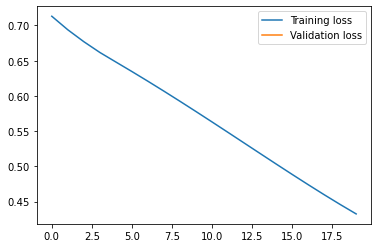

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()